# Progetto DL24: YesWeKAN

introduzione

### Importazione librerie

Importiamo tutte le librerie necessarie per il notebook:

In [1]:
# Libreirie di sistema
import os
import random
import base64
import datetime

# Array, dataframe e tensori
import numpy as np
import pandas as pd
import tensorflow as tf

# Modelli ML & DL
import keras
from tensorflow.keras.layers import Dense
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import check_random_state
from keras_tuner import HyperModel, GridSearch, RandomSearch
from keras_tuner.tuners import BayesianOptimization
import lime # fornisce metodi di spiegabilità algoritmic
import lime.lime_tabular 

# Librerie grafiche
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
import matplotlib.pyplot as plt # fornisce funzioni per generare grafici
import seaborn as sns
import networkx as nx # fornisce funzioni per la creazione di grafi

# Librerie custom
import preprocess_dataset as ut
from tfkan import DenseKAN

Impostiamo in seme casuale a 0 per poter rendere l'esperimento ripetibile:

In [2]:
# Valore del seme causale
seed_value = 0

# Impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Controllo che il seme sia stato correttamente impostato
check_random_state(seed_value)

RandomState(MT19937) at 0x19D79EC6440

## Dataset

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [3]:
# Variabili del dataset
DATASET_NAME = 'LengthOfStay'
FEATURES = [ # Nomi feature accorciati (per migliorare la visualizzazione nei grafici)
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

# Numero feature usate dal modello
N_FEATURES = len(FEATURES)

# Definisce i colori da usare per le barre
COLORS = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  

# Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

# Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

### Analisi del dataset

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [4]:
# Genera statistiche sul dataset
fsg = FeatureStatisticsGenerator()
dataframes = [ {'table': df, 'name': DATASET_NAME}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")

# Impostazioni per la visualizzazione
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)

# Mostra analisi grafica
display(HTML(html)) 

c:\Users\matte\documents\KAN\Lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

### Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare la data di fine ricovero, in quanto non è un'informazione che ci dovrebbe essere nota al momento della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

- **eid**: è un identificativo univoco del record nel dataset; non porta alcuna informazione, per cui non lo consideriamo.

Dopo aver eliminato le colonne che non consideriamo, ma prima di trasformare dati categorici in numerici, ci salviamo una copia del dataset per i modelli di ML, che possono gestire anche dati categorici.

In [5]:
# Rimuove la colonna "discharged"
df.drop("discharged", axis=1, inplace=True) 

# Rimuove la colonna "eid"
df.drop("eid", axis=1, inplace=True)

# Codifica del 5+ in 5 in rcount
keys = sorted(df["rcount"].unique())
values = range(len(keys))
df.replace({"rcount": dict(zip(keys, values))}, inplace=True)

# Codifica delle date
keys = df["vdate"].unique()
values = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in keys]
df.replace({"vdate": dict(zip(keys, values))}, inplace=True)

# Codifica del genere
keys = df["gender"].unique()
values = range(len(keys))
df.replace({"gender": dict(zip(keys, values))}, inplace=True)

# Codifica del facid
keys = df["facid"].unique()
values = range(len(keys))
df.replace({"facid": dict(zip(keys, values))}, inplace=True)

Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati.
Svolgiamo quindi una standardizzazione MinMax, per portare tutti i valori nell'intervallo [0, 1]. La svolgiamo attraverso la funzione `standardize`, inserita nella nostra libreria.

In [6]:
# Standardizzazione degli attributi del dataset
df = df.astype(float)
df.iloc[:, :-1] = ut.standardize(df.iloc[:, :-1])

### Separazione del dataset

A questo punto il dataset ha solamente valori numerici. Separiamo i training set, validation set e test set, creando a parte dei dataset per addestrare i modelli di ML. Dopo esserci salvati in alcuni csv la separazione, convertiamo il dataframe in un tensore di Tensorflow.

In [7]:
# Definizione rapporti di split
test_ratio = 0.20
val_ratio = 0.20

# Funzione per separare train, validation, test
def train_val_test_split(df: pd.DataFrame, test_ratio: float, val_ratio: float | None) -> tuple[pd.DataFrame]:
    val_ratio = val_ratio or 0
    x_train_val, x_test, y_train_val, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=test_ratio)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_ratio*len(df)/len(x_train_val))
    return x_train, y_train, x_val, y_val, x_test, y_test

# Separazione train, validation, test
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(df, test_ratio, val_ratio)

# Creazione dei dataset di train, validation, test
x_train.to_csv("datasets/x_train.csv", index=False)
y_train.to_csv("datasets/y_train.csv", index=False)
x_val.to_csv("datasets/x_val.csv", index=False)
y_val.to_csv("datasets/y_val.csv", index=False)
x_test.to_csv("datasets/x_test.csv", index=False)
y_test.to_csv("datasets/y_test.csv", index=False)

# Conversione del dataframe in tensore
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

#stampa le dimensioni dei nuovi dataset creati
print("train: ", x_train.shape," validation: ",  x_val.shape," test: ",  x_test.shape)

train:  (60000, 25)  validation:  (20000, 25)  test:  (20000, 25)


Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN recentemente introdotta possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte dalle reti fully connected agli algoritmi più tradizionali.

Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Utilizzeremo le metriche tipiche di un task di regressione cioè **MSE**, **MAE** e **RMSE** (quest'ultima è stata definita da noi in quanto non presente nella suite di Tensorflow).

In [9]:
# Lista di metriche necessarie per valutare le performance 
METRICS_NAME = {"mean_absolute_error":"mae", "mean_squared_error":"mse", "root_mean_squared_error":"rmse"}

METRICS = [tf.keras.metrics.get(metric_name) for metric_name in METRICS_NAME]
for metric in METRICS:
    metric.name = METRICS_NAME[metric.name]

BATCH_SIZE = 128
EPOCHS = 10
LOSS = "mse"

# Lista performance dei vari modelli
histories = []

# Lista dei modelli addestrati di DL e ML
elenco_modelli = []
elenco_modelliML = []

# Definizione architettura KAN Classica

In [10]:
# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(8),
    DenseKAN(4),
    DenseKAN(1)
])
kan.build(input_shape=(None, N_FEATURES))
kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0050089061837515795), loss=LOSS, metrics=METRICS)

# Stampa forma e numero di parametri
kan.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 8)              │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 4)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_2 (DenseKAN)          │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416 (5.53 KB)

 Trainable params: 1,416 (5.53 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestriamo la kan:

In [11]:
# Addestra il modello e ottiene le performance delle varie metriche
kan_history = kan.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)

# Aggiunge modello e sue performance alle liste
histories.append(('KAN', kan_history))
elenco_modelli.append(('KAN', kan))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 10.0332 - mae: 2.2972 - mse: 10.0332 - rmse: 3.0763 - val_loss: 0.7456 - val_mae: 0.6129 - val_mse: 0.7456 - val_rmse: 0.8635
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6789 - mae: 0.6045 - mse: 0.6789 - rmse: 0.8237 - val_loss: 0.5954 - val_mae: 0.5562 - val_mse: 0.5954 - val_rmse: 0.7716
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5513 - mae: 0.5442 - mse: 0.5513 - rmse: 0.7424 - val_loss: 0.5842 - val_mae: 0.5466 - val_mse: 0.5842 - val_rmse: 0.7644
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5081 - mae: 0.5155 - mse: 0.5081 - rmse: 0.7127 - val_loss: 0.5778 - val_mae: 0.5357 - val_mse: 0.5778 - val_rmse: 0.7601
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4879 - mae: 0.5007 - mse: 0.4879 - rmse: 0.6985 - val_loss: 0.5516 - val_mae: 0.5197 - val_mse: 0.5516 - val_rmse: 0.7427
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4754 - mae: 0.49

# Definizione architettura MLP Classica

In [13]:
# Creazione del modello MLP
mlp = tf.keras.models.Sequential([
    Dense(1),
    Dense(1),
    Dense(1)
    ])
mlp.build(input_shape=(None, N_FEATURES))
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=LOSS, metrics=METRICS)

# Stampa forma e numero di parametri
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo la MLP:

In [14]:
# Addestra il modello e ottiene le performance delle varie metriche
mlp_history = mlp.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)

# Aggiunge modello e sue performance alle liste
histories.append(('MLP', mlp_history))
elenco_modelli.append(('MLP', mlp))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8395 - mae: 1.4105 - mse: 4.6649 - rmse: 2.1502 - val_loss: 2.7484 - val_mae: 1.3483 - val_mse: 2.7484 - val_rmse: 1.6578
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3203 - mae: 1.2150 - mse: 2.3203 - rmse: 1.5204 - val_loss: 1.5017 - val_mae: 0.9303 - val_mse: 1.5017 - val_rmse: 1.2254
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4595 - mae: 0.9178 - mse: 1.4595 - rmse: 1.2079 - val_loss: 1.4272 - val_mae: 0.9076 - val_mse: 1.4272 - val_rmse: 1.1946
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4086 - mae: 0.9018 - mse: 1.4086 - rmse: 1.1867 - val_loss: 1.4047 - val_mae: 0.9002 - val_mse: 1.4047 - val_rmse: 1.1852
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3891 - mae: 0.8955 - mse: 1.3891 - rmse: 1.1784 - val_loss: 1.3907 - val_mae: 0.8947 - val_mse: 1.3907 - val_rmse: 1.1793
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3773 - mae: 0.8918

# Definizione architerrura KAN-MLP 1 (Livelli misti)

In [128]:
# Creazione del modello KAN-MLP 1
kanmix1 = tf.keras.models.Sequential([
    DenseKAN(1),
    Dense(1),
    DenseKAN(1)
])
kanmix1.build(input_shape=(None, N_FEATURES))
kanmix1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=LOSS, metrics=METRICS)

# Stampa forma e numero di parametri
kanmix1.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_36 (DenseKAN)         │ (None, 1)              │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_37 (DenseKAN)         │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158 (632.00 B)

 Trainable params: 158 (632.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [129]:
# Addestra il modello e ottiene le performance delle varie metriche
kanmix1_history = kanmix1.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)

# Aggiunge modello e sue performance alle liste
histories.append(('KAN_MIX1', kanmix1_history))
elenco_modelli.append(('KAN_MIX1', kanmix1))

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 18.1574 - mae: 2.5320 - mse: 10.8985 - rmse: 3.2809 - val_loss: 8.1421 - val_mae: 2.2075 - val_mse: 8.1421 - val_rmse: 2.8534


# Definizione architettura Albero Decisionale

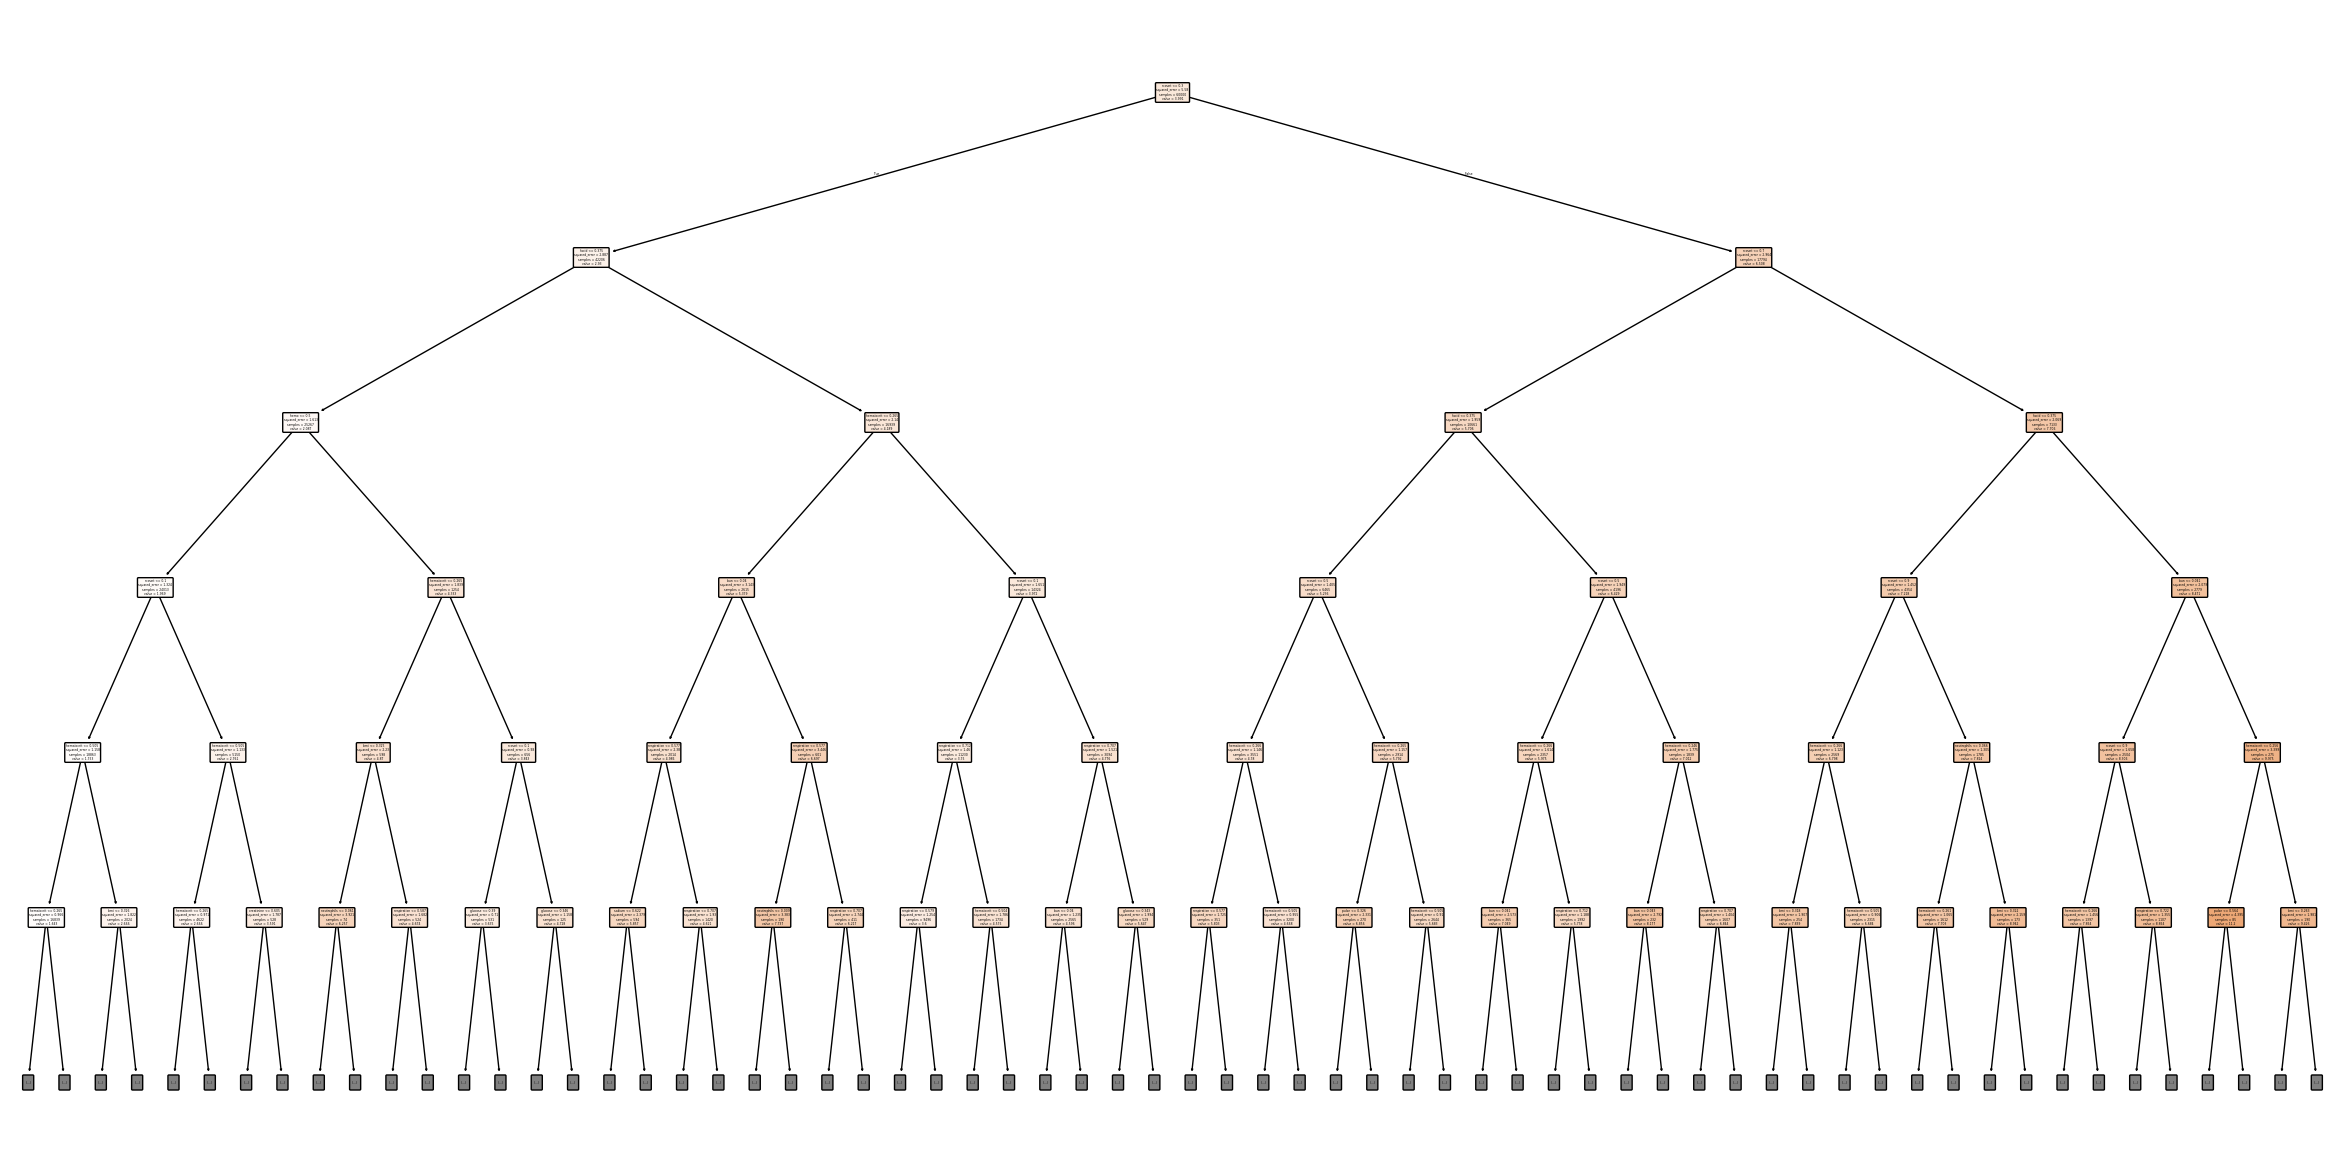

In [15]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(
    ccp_alpha=0.0003470446359305824,
    criterion='squared_error',
    max_depth=10,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    random_state=0,
    splitter='best'
)

# Addestramento
tree.fit(x_train, y_train)

# Aggiunge il modello alla lista modelli
elenco_modelliML.append(('TREE', tree))

# Disegna l'albero
plt.figure(figsize=(30,15))
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=FEATURES)
plt.show()

# Definizione architettura Random Forest

In [131]:
#definisce la random forest
forest = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=10,
    max_features=1.0,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=145,
    random_state=0,
    verbose=0,
    warm_start=False
)

# Addestramento
forest.fit(x_train, y_train)

# Aggiunge il modello alla lista modelli
elenco_modelliML.append(('FOREST', forest))

# Definizione architettura Ensemble
Come modello Ensemble utilizziamo un regressore composto da un albero decisionale, un regressore lineare e uno bayesiano

In [132]:
# Crea il modello di ensemble
ensemble = VotingRegressor(
    estimators=[
        ('tree', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=0)),
        ('linear', LinearRegression(copy_X=True, fit_intercept=True)),
        ('bayes', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True, fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, tol=0.001, verbose=False))
    ],
    n_jobs=None,
    verbose=False,
    weights=None
)

# Addestramento
ensemble.fit(x_train, y_train)

# Aggiunge il modello alla lista modelli
elenco_modelliML.append(('ENSEMBLE', ensemble))

## Confronto modelli

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step


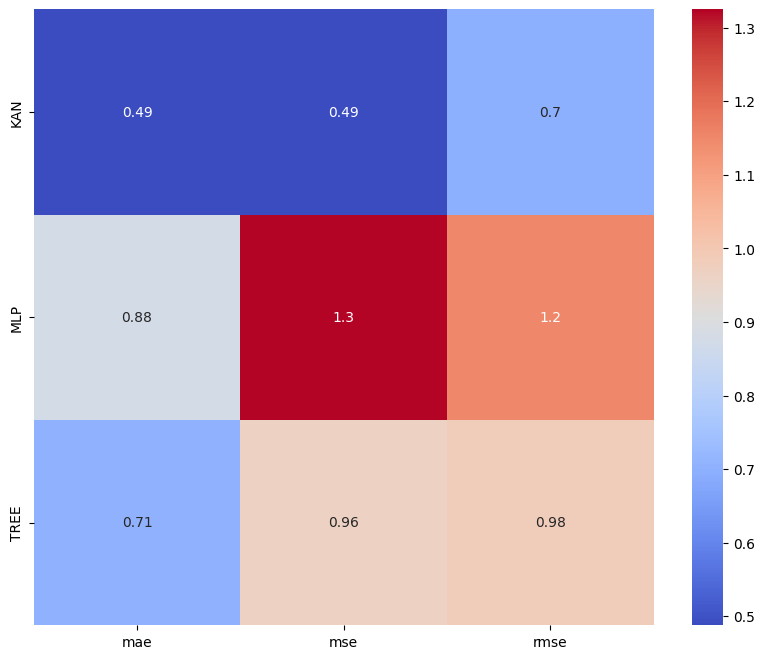

In [16]:
# Definizione funzione per calcolo metriche di errore del modello
def calculate_metrics(model, X, y):
    # Calcolo delle previsioni del modello
    predictions = model.predict(X)

    # Calcolo metriche
    result = {}
    for metric in METRICS:
        metric.reset_state()
        result[metric.name] = float(metric(y, predictions))
    return result

# Definizione funzione visualizzazione heatmap delle performance dei modelli
def performance_heatmap(models, X, y):
    # Inizializzazione del dizionario delle performance
    performance = {metric: [] for metric in METRICS_NAME.values()}
    model_names = []

    for model_name, model in models:
        # Calcolo delle metriche per il modello corrente
        result_metrics = calculate_metrics(model, X, y)

        # Aggiunta delle metriche al dizionario delle performance
        for name, result in result_metrics.items():
            performance[name].append(result)

        # Aggiunta del nome del modello alla lista dei nomi dei modelli
        model_names.append(model_name)

    # Creazione di un DataFrame con le performance dei modelli
    df = pd.DataFrame(performance, index=model_names)

    # Visualizzazione della heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm')
    plt.show()

performance_heatmap(elenco_modelli + elenco_modelliML, x_test, y_test)


# Prestazione dei modelli di apprendimento automatico

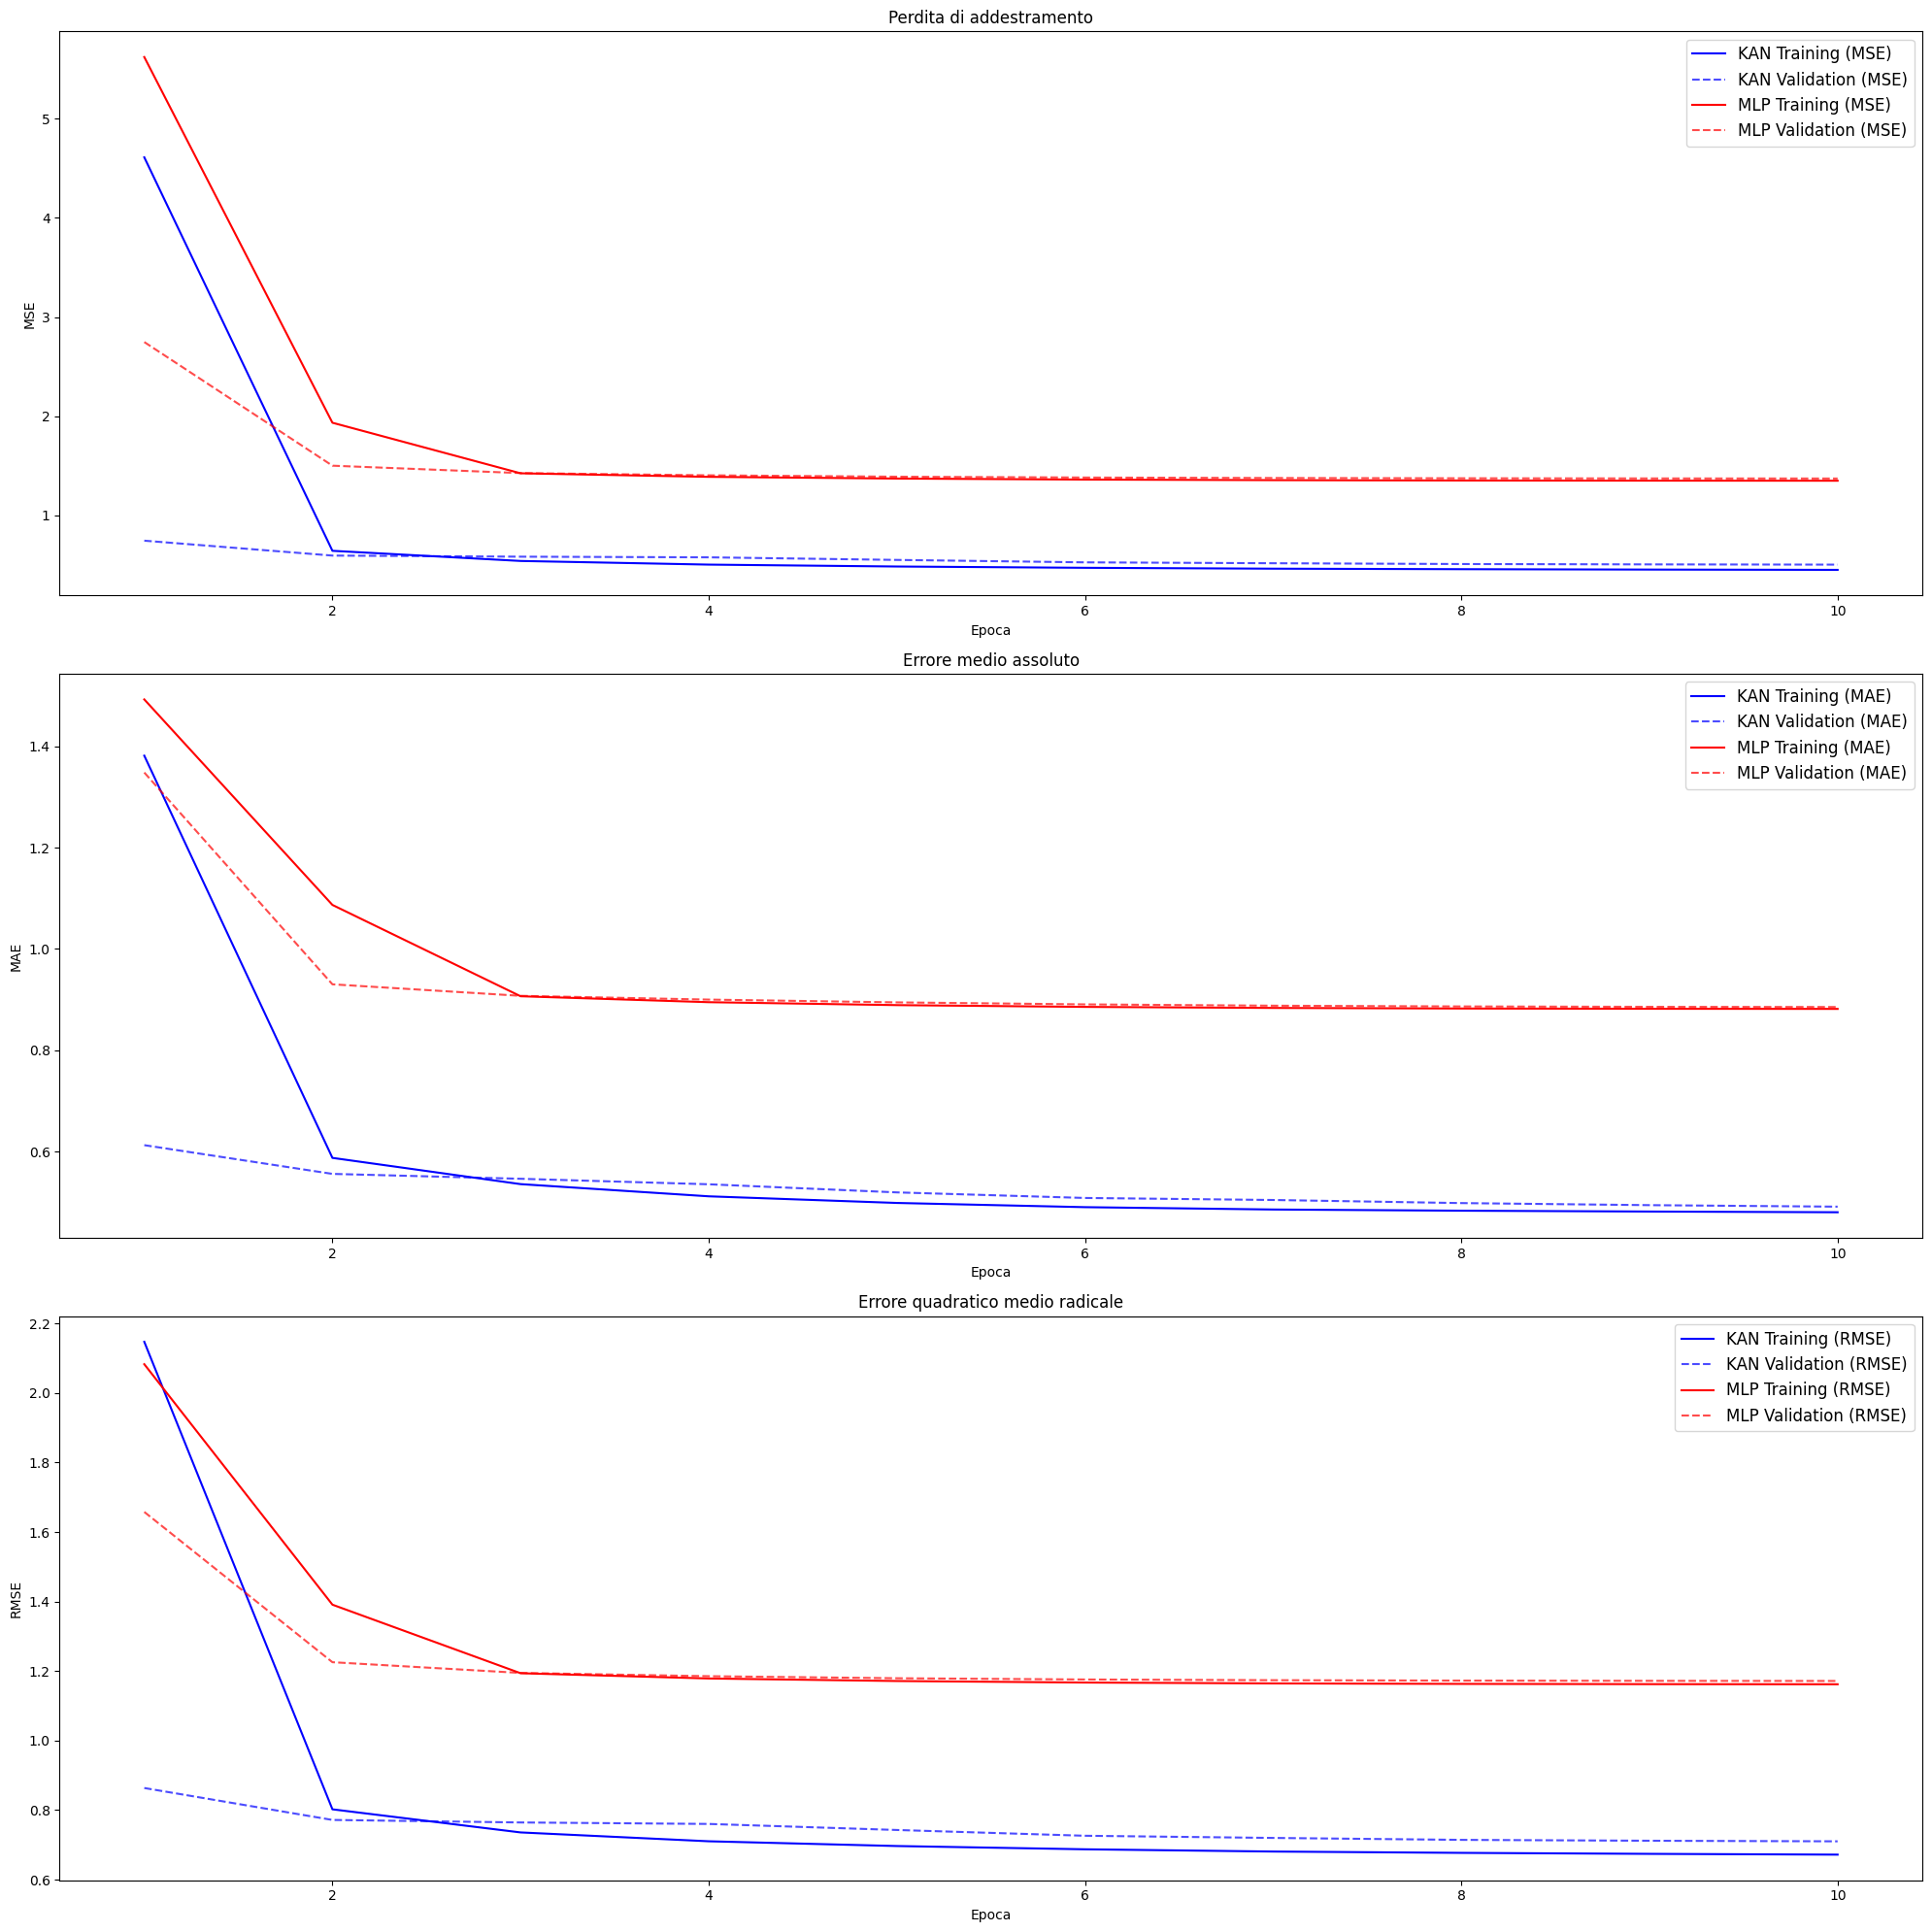

In [17]:
# Definizione funzione di creazione linechart
def plot_data(ax, epochs, metric, val_metric, model_name, metric_name, color):
    ax.plot(epochs, metric, color, label=f'{model_name} Training ({metric_name})') 
    ax.plot(epochs, val_metric, color+'--', alpha=0.7, label=f'{model_name} Validation ({metric_name})') 
    ax.set_xlabel('Epoca')
    ax.legend(fontsize='large')

plt.figure(figsize=(20, 20))

# Crea subplot per ogni metrica
ax1 = plt.subplot(3, 1, 1)
ax1.set_title('Perdita di addestramento')
ax1.set_ylabel('MSE')

ax2 = plt.subplot(3, 1, 2)
ax2.set_title('Errore medio assoluto')
ax2.set_ylabel('MAE')

ax3 = plt.subplot(3, 1, 3)
ax3.set_title('Errore quadratico medio radicale')
ax3.set_ylabel('RMSE')

# Per ogni modello associato al suo colore
for (model_name, history), color in zip(histories, COLORS):

    # Salvataggio performance
    loss, val_loss, mae, val_mae, rmse,val_rmse = history.history['loss'], history.history['val_loss'], history.history['mae'], history.history['val_mae'], history.history['rmse'], history.history['val_rmse']

    # Calcolo numero di epoche 
    epochs = range(1, len(loss) + 1)

    # Creazione 3 plot con performance di train e validation al variare delle epoche
    plot_data(ax1, epochs, loss, val_loss, model_name, 'MSE', color)
    plot_data(ax2, epochs, mae, val_mae, model_name, 'MAE', color)
    plot_data(ax3, epochs, rmse, val_rmse, model_name, 'RMSE', color)

plt.tight_layout()
plt.show()


# Analisi equità di genere

Abbiamo valutato varie metriche dei vari modelli per l'attributo gender che rappresenta un attributo sensibile

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


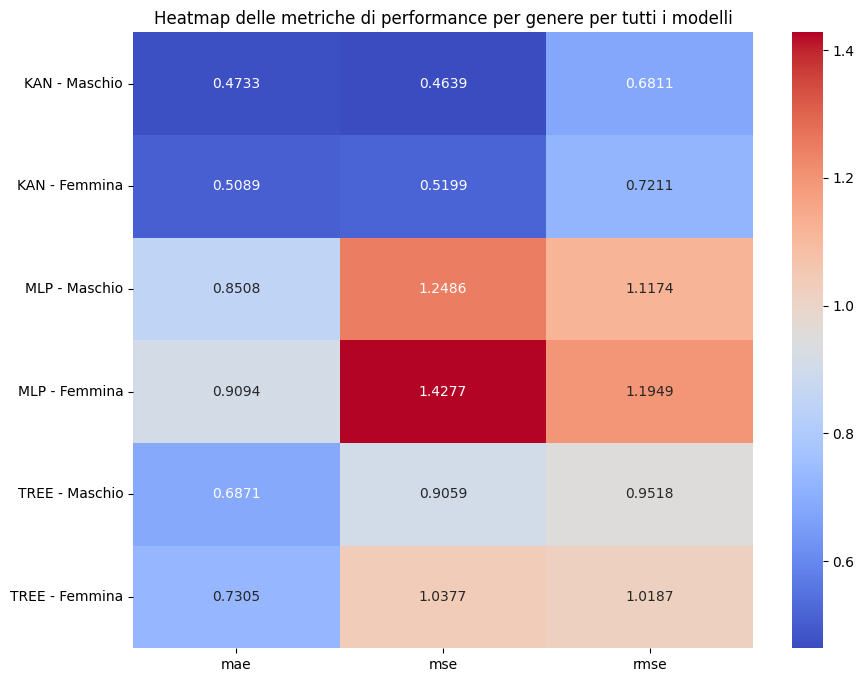

In [18]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

for model_name, model in elenco_modelli + elenco_modelliML:
    results = {}

    for sg in SUBGROUPS: 
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg #crea una maschera booleana
        features1 = x_test[subgroup_indices] #salva i record relativi al sottogruppo corrente
        labels = y_test[subgroup_indices]  #salva le label relative al sottogruppo corrente
        
        # Calcolo delle metriche per ciascun sottogruppo
        results[sg] = calculate_metrics(model, features1, labels).values()

    all_results[model_name] = results

# Creazione Dataframe performance
df = pd.DataFrame()

for model_name, results in all_results.items():

    # Definizone dataframe di un modello
    temp_df = pd.DataFrame(results, index=METRICS_NAME.values())
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']

    # Concatenazione dataframe di un modello ai precedenti
    df = pd.concat([df, temp_df], axis=1)

# Processamento del dataset
df = df.astype(float)
df = df.transpose()

# Visualizzazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()

# Trasparenza algoritmica

## Feature importance

Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.

In [136]:
# Calcola feature importance del modello
def calculate_feature_importance(model, X, y):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
        importance = results.importances_mean

    # Ritorna un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(FEATURES, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per ogni modello
caratteristiche = []
for nome, modello in elenco_modelli + elenco_modelliML:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
625/625 ━━━

In [144]:
importanze = {}

for nome_modello, importanza_caratteristiche in caratteristiche:
    importanze[nome_modello] = {}

    # Stampa il nome del modello
    print(f"\n Modello: {nome_modello}")
    
    # Calcola totale delle importanze
    totale = sum(abs(imp) for imp in importanza_caratteristiche.values())
    
    # Stampa le caratteristice e la loro importanza normalizzata
    for caratteristica, importanza in importanza_caratteristiche.items():
        importanze[nome_modello][caratteristica] = importanza / totale

        print(f"Caratteristica: {caratteristica}, Importanza: {importanza:.2f}, Importanza nortmalizzata: {((importanza / totale)):.2f}")
        


 Modello: KAN
Caratteristica: vdate, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: rcount, Importanza: 6.45, Importanza nortmalizzata: 0.69
Caratteristica: gender, Importanza: 0.00, Importanza nortmalizzata: 0.00
Caratteristica: dialysis, Importanza: 0.12, Importanza nortmalizzata: 0.01
Caratteristica: asthma, Importanza: 0.08, Importanza nortmalizzata: 0.01
Caratteristica: irondef, Importanza: 0.21, Importanza nortmalizzata: 0.02
Caratteristica: pneum, Importanza: 0.08, Importanza nortmalizzata: 0.01
Caratteristica: subdep, Importanza: 0.19, Importanza nortmalizzata: 0.02
Caratteristica: psychmaj, Importanza: 0.68, Importanza nortmalizzata: 0.07
Caratteristica: depress, Importanza: 0.09, Importanza nortmalizzata: 0.01
Caratteristica: psychother, Importanza: 0.11, Importanza nortmalizzata: 0.01
Caratteristica: fibrosis, Importanza: 0.02, Importanza nortmalizzata: 0.00
Caratteristica: malnutr, Importanza: 0.10, Importanza nortmalizzata: 0.01
Caratteristica: hemo, Imp

Stampiamo graficamente i risultati della feature importance:

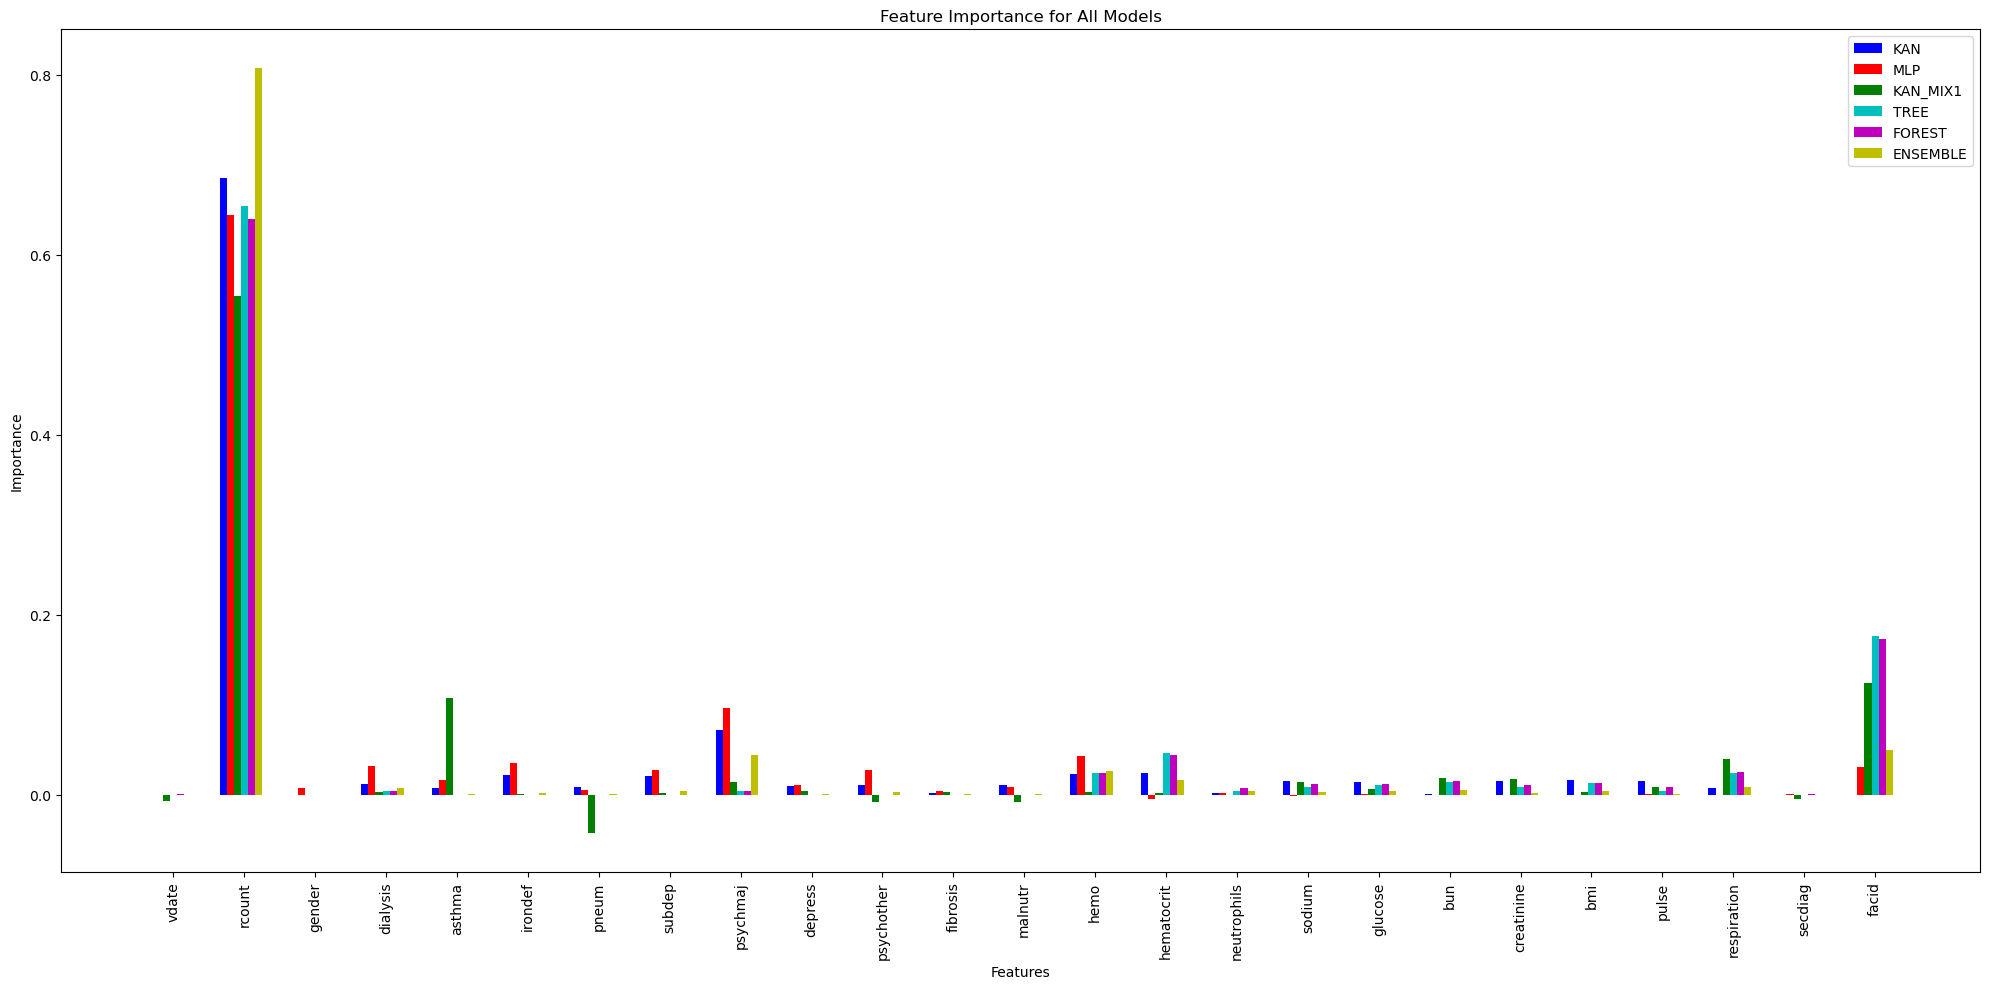

In [154]:
# Crea le etichette per l'asse x
features = list(importanze[list(importanze.keys())[0]].keys())
x = np.arange(len(features))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))

# Calcola la larghezza delle barre in base al numero di modelli
BAR_WIDTH = 0.6
bar_width = BAR_WIDTH / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello di un certo colore
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - BAR_WIDTH/2 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=COLORS[i % len(COLORS)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

# LIME

Il metodo LIME (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le previsioni di modelli complessi tramite modelli interpretabili e locali. LIME perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, LIME costruisce un modello interpretabile (ad esempio, una regressione lineare) sulle predizioni del modello complesso solo per l'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni, rendendo le sue predizioni più comprensibili e trasparenti.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Errore nell'applicazione di LIME al modello TREE:
Errore nell'applicazione di LIME al modello FOREST:
Errore nell'applicazione di LIME al modello ENSEMBLE:


Traceback (most recent call last):
  File "C:\Users\gobba\AppData\Local\Temp\ipykernel_14204\2166946240.py", line 134, in <module>
    feature_importance, predicted_value = apply_lime(model, xML_train, xML_test)
NameError: name 'xML_train' is not defined
Traceback (most recent call last):
  File "C:\Users\gobba\AppData\Local\Temp\ipykernel_14204\2166946240.py", line 134, in <module>
    feature_importance, predicted_value = apply_lime(model, xML_train, xML_test)
NameError: name 'xML_train' is not defined
Traceback (most recent call last):
  File "C:\Users\gobba\AppData\Local\Temp\ipykernel_14204\2166946240.py", line 134, in <module>
    feature_importance, predicted_value = apply_lime(model, xML_train, xML_test)
NameError: name 'xML_train' is not defined


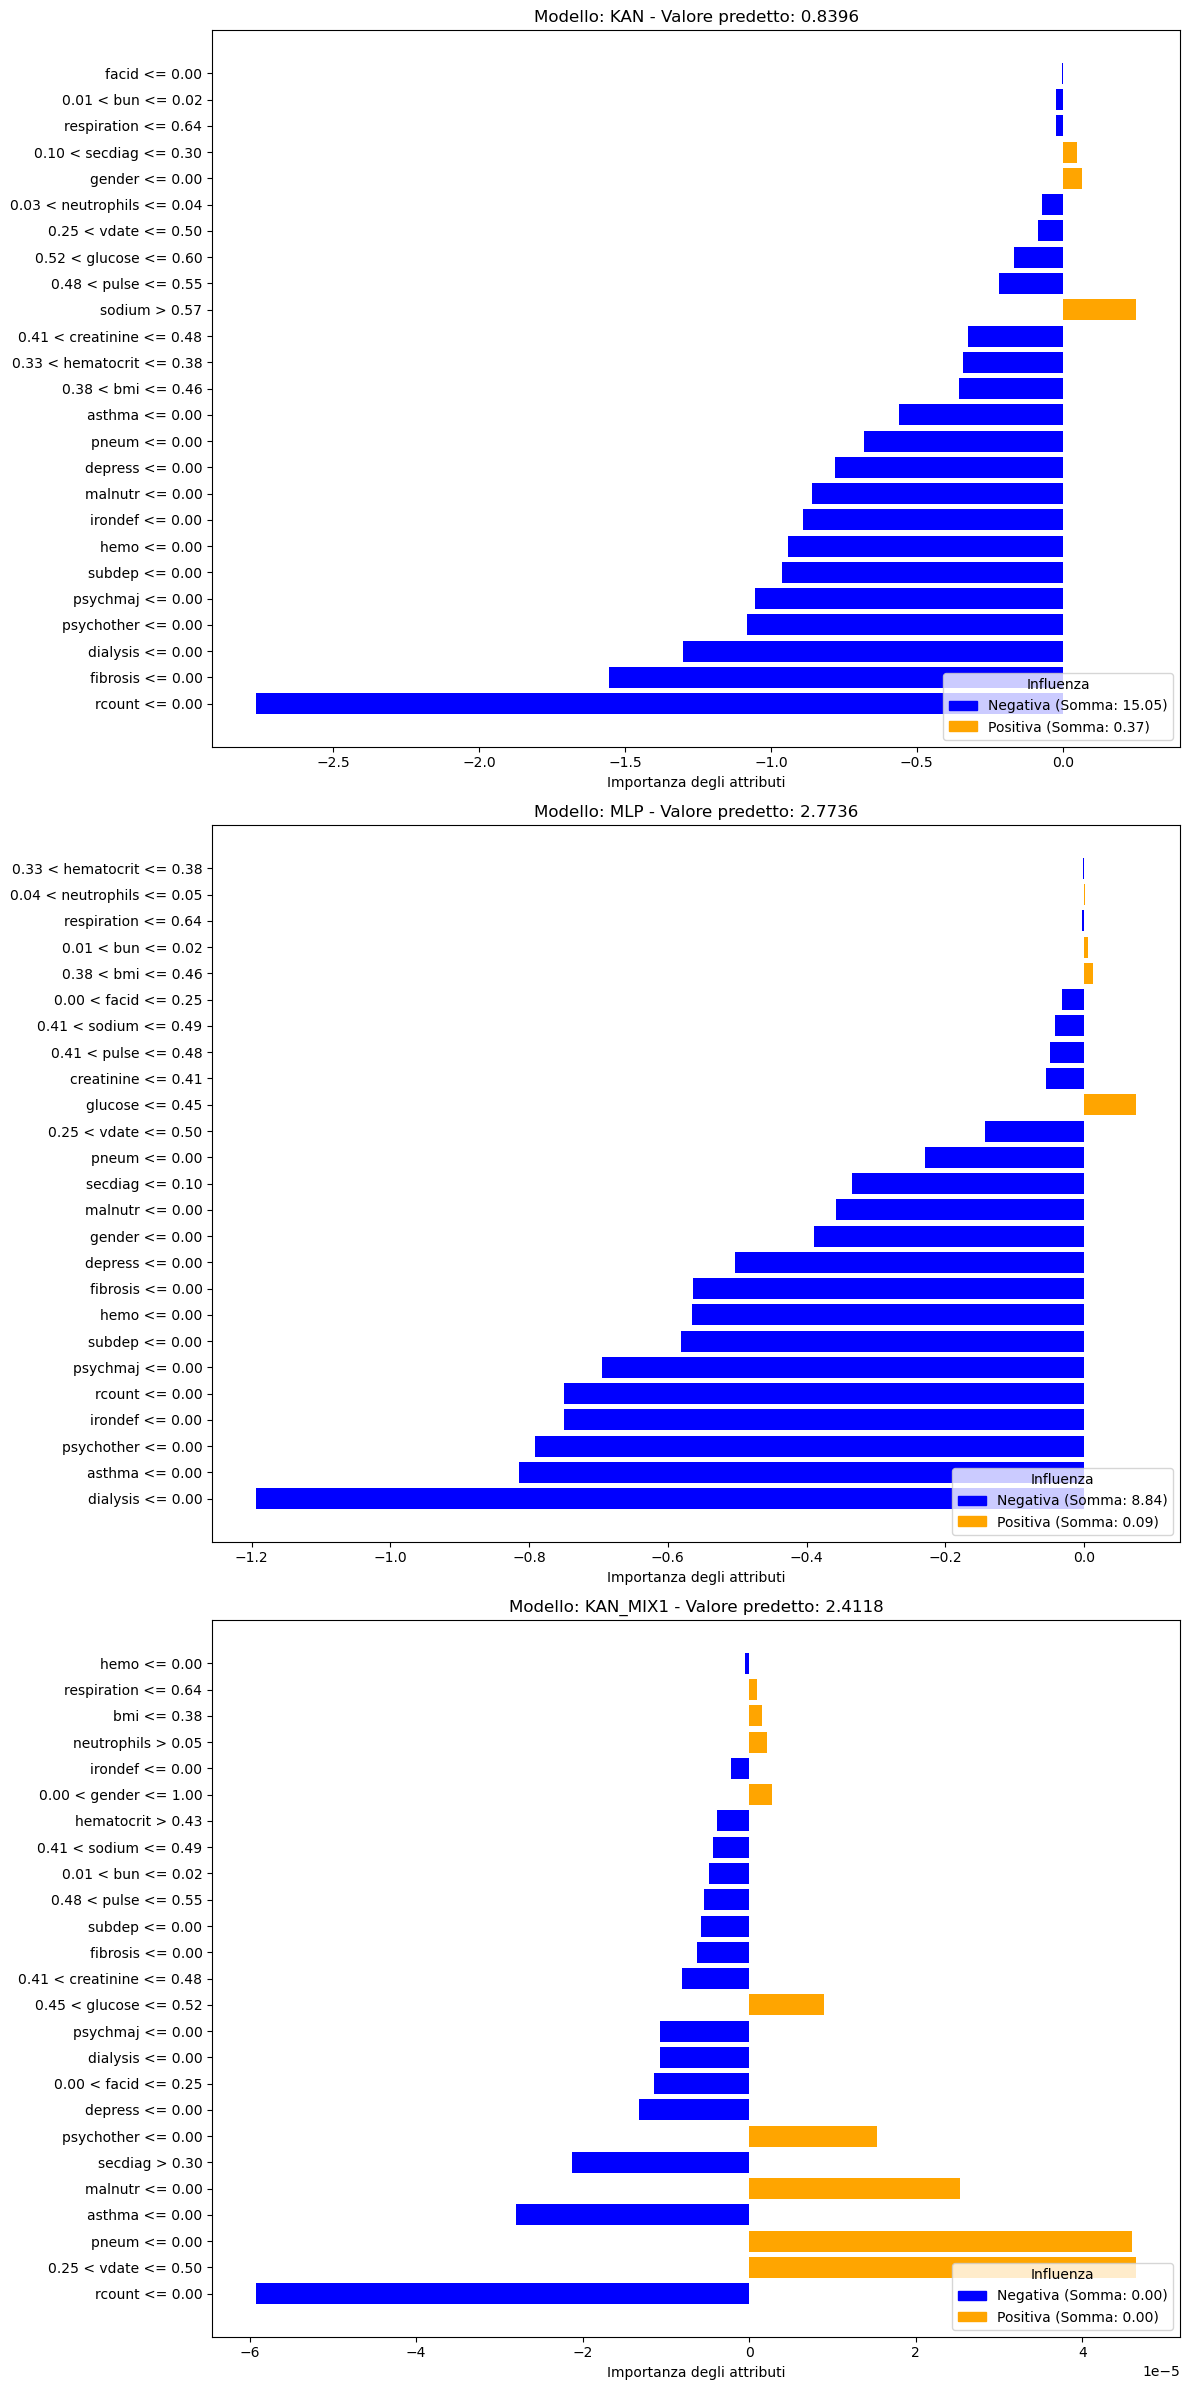

In [139]:
# Definizione della funzione 'check_and_reshape_data' che prende in input un array X e lo ridimensiona se necessario
def check_and_reshape_data(X):
    # Se X ha una sola dimensione, lo ridimensiona a (-1, 1)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    # Se X ha più di due dimensioni, lo ridimensiona a (X.shape[0], -1)
    elif X.ndim > 2:
        return X.reshape(X.shape[0], -1)
    # Altrimenti, restituisce X così com'è
    return X

# Definizione della funzione 'check_and_convert_data' che prende in input un array X e lo converte in un array numpy se necessario
def check_and_convert_data(X):
    # Se X è un DataFrame, restituisce i suoi valori
    if isinstance(X, pd.DataFrame):
        return X.values
    # Se X ha l'attributo 'numpy', restituisce X.numpy()
    elif hasattr(X, 'numpy'):
        return X.numpy()
    # Altrimenti, restituisce X così com'è
    return X

# Definizione della funzione 'apply_lime' che applica LIME a un modello e a un set di dati
def apply_lime(model, X_train, X_test):
    # Conversione di X_train e X_test in array numpy se necessario
    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train.numpy() if hasattr(X_train, 'numpy') else X_train
    X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test.numpy() if hasattr(X_test, 'numpy') else X_test

    # Creazione di un oggetto LimeTabularExplainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_np,
        feature_names=features,
        class_names=['target'],
        mode='regression'
    )
    
    # Definizione della funzione 'model_predict' che prende in input dei dati
    # e restituisce le previsioni del modello su quei dati
    def model_predict(input_data):
        # Ridimensionamento dei dati di input se necessario
        input_data = input_data.reshape(1, -1) if input_data.ndim == 1 else input_data
        # Conversione dei dati di input in un DataFrame o in un tensore tensorflow se necessario
        if isinstance(X_train, pd.DataFrame):
            input_data = pd.DataFrame(input_data, columns=X_train.columns)
        elif hasattr(X_train, 'numpy'):
            input_data = tf.convert_to_tensor(input_data)
        # Restituzione delle previsioni del modello sui dati di input
        return model.predict(input_data)
    
    # Selezione di un'istanza casuale da X_test_np
    instance = X_test_np[random.randint(0, len(X_test_np)-1)]
    # Spiegazione dell'istanza selezionata con LIME
    explanation = explainer.explain_instance(instance, model_predict, num_features=len(features))
    
    # Calcolo della previsione del modello sull'istanza selezionata
    prediction = model_predict(instance.reshape(1, -1))
    # Estrazione del valore predetto dall'array di previsioni
    predicted_value = prediction[0] if isinstance(prediction, np.ndarray) else prediction
    
    # Restituzione della lista di spiegazioni e del valore predetto
    return explanation.as_list(), predicted_value

# Definizione della funzione 'plot_lime_results' che prende in input tutti i risultati di LIME
# e li visualizza in un grafico
def plot_lime_results(all_results):
    # Calcolo del numero di modelli
    n_models = len(all_results)
    # Se non ci sono modelli, termina la funzione
    if n_models == 0:
        return
    
    # Creazione di una figura con un subplot per ogni modello
    fig, axs = plt.subplots(n_models, 1, figsize=(12, 8*n_models), squeeze=False)
    
    # Per ogni modello nei risultati
    for i, (model_name, feature_importance, predicted_value) in enumerate(all_results):
        # Estrazione degli attributi e delle importanze
        attributi, importances = zip(*feature_importance)
        # Assegnazione di un colore a ciascuna importanza in base al suo segno
        colors = ['blue' if imp < 0 else 'orange' for imp in importances]
        
        # Creazione di un grafico a barre orizzontali con le importanze
        ax = axs[i, 0]
        bars = ax.barh(range(len(attributi)), importances, color=colors)
        ax.set_yticks(range(len(attributi)))
        ax.set_yticklabels(attributi)
        ax.set_xlabel('Importanza degli attributi')
        
        # Conversione del valore predetto in una stringa
        if isinstance(predicted_value, np.ndarray):
            predicted_value_str = ', '.join([f'{v:.4f}' for v in predicted_value.flatten()])
        else:
            predicted_value_str = f'{predicted_value:.4f}'
        
        # Impostazione del titolo del subplot
        ax.set_title(f'Modello: {model_name} - Valore predetto: {predicted_value_str}')
        ax.set_facecolor('white')
        
        # Calcolo della somma delle importanze positive e negative
        positive_sum = sum(abs(imp) for imp in importances if imp > 0)
        negative_sum = sum(abs(imp) for imp in importances if imp < 0)
        
        # Aggiunta di una leggenda con le somme delle importanze
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]
        ax.legend(handles, [f'Negativa (Somma: {negative_sum:.2f})', 
                            f'Positiva (Somma: {positive_sum:.2f})'], 
                  title='Influenza', loc='lower right')
    
    # Ridimensionamento del layout del grafico
    plt.tight_layout()
    # Visualizzazione del grafico
    plt.show()
    
# Inizializzazione di una lista vuota per raccogliere i risultati di LIME per tutti i modelli
all_results = []

# Applicazione di LIME a tutti i modelli in elenco_modelli
for name, model in elenco_modelli:
    try:
        # Calcolo dell'importanza delle caratteristiche e del valore predetto con LIME
        feature_importance, predicted_value = apply_lime(model, x_train, x_test)
        # Aggiunta dei risultati alla lista 'all_results'
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        # Stampa dell'errore se si verifica un'eccezione
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Applicazione di LIME a tutti i modelli in elenco_modelliML
for name, model in elenco_modelliML:
    try:
        # Calcolo dell'importanza delle caratteristiche e del valore predetto con LIME
        feature_importance, predicted_value = apply_lime(model, xML_train, xML_test)
        # Aggiunta dei risultati alla lista all_results
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        # Stampa un errore se si verifica un'eccezione
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Visualizzazione dei risultati
if all_results:
    plot_lime_results(all_results)
else:
    print("Nessun risultato da visualizzare.")


## Grafico Architettura KAN

AttributeError: 'list' object has no attribute 'knots'

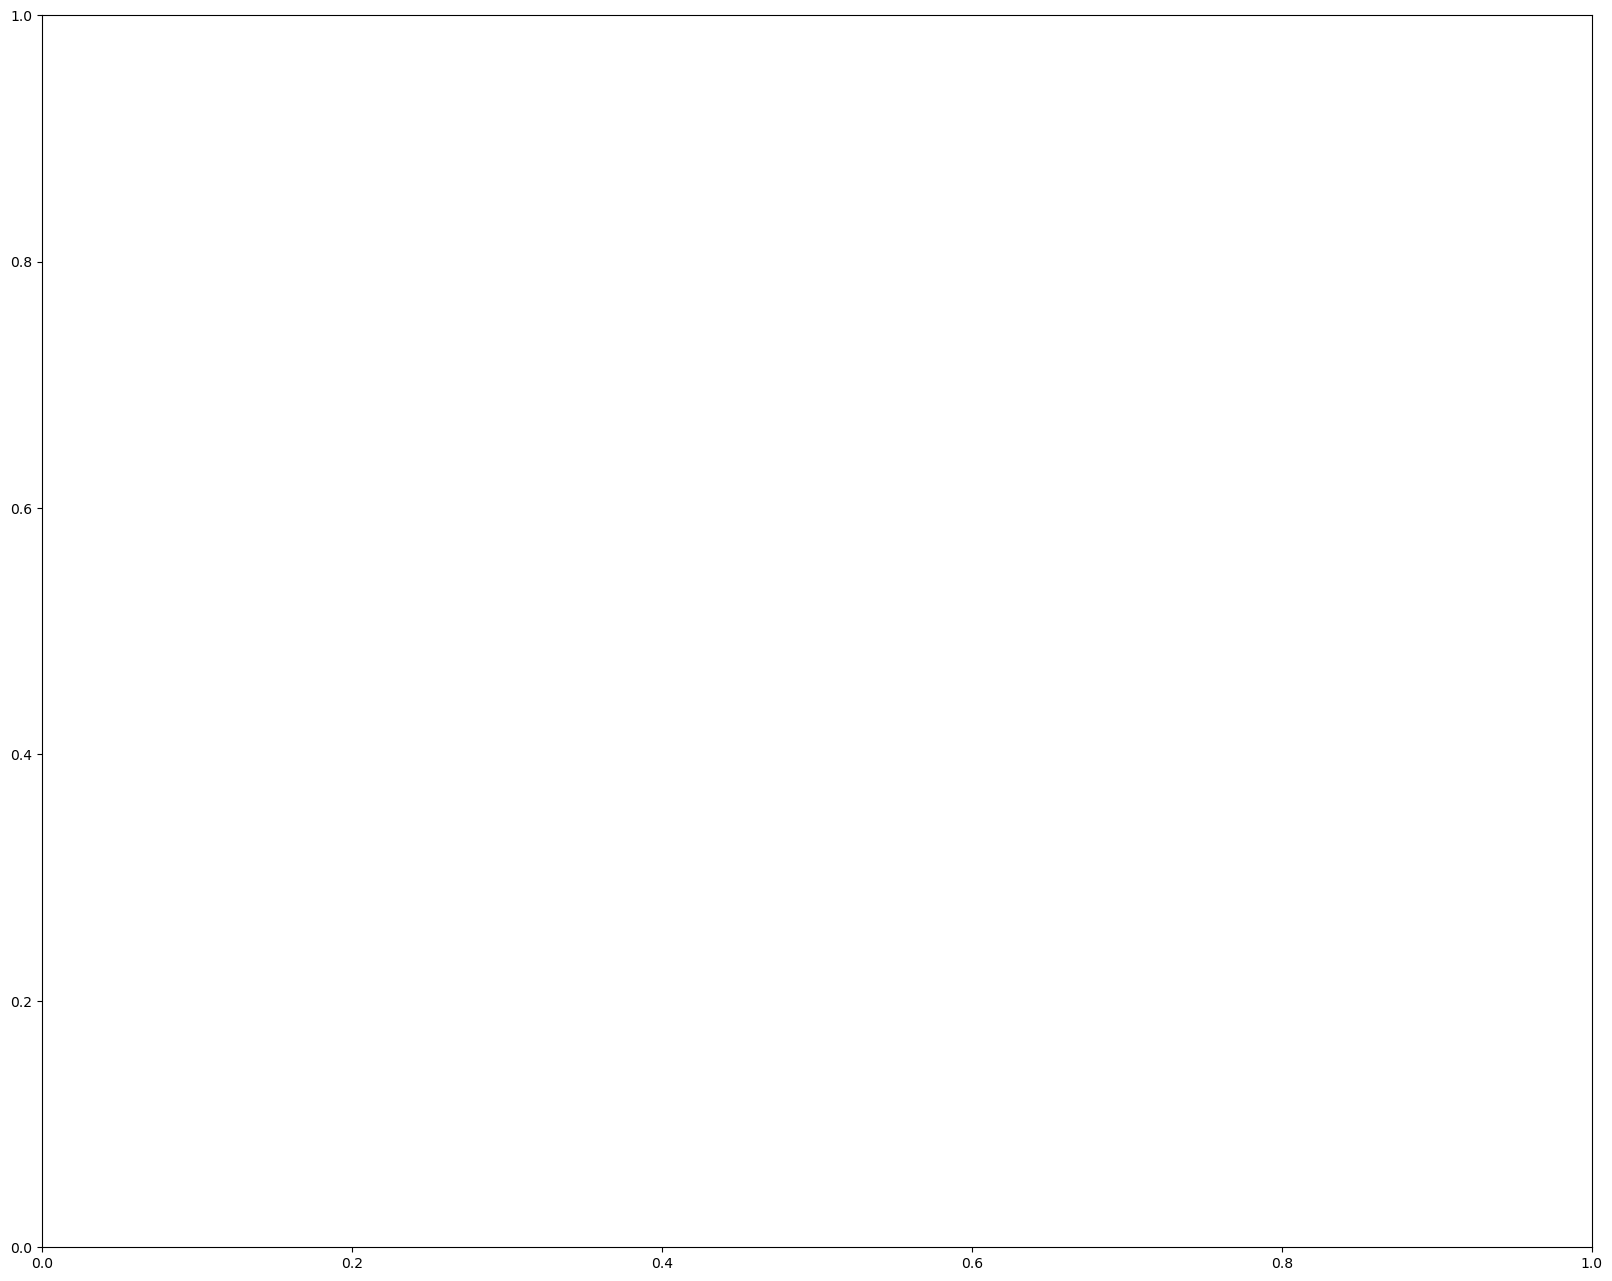

In [140]:
# Definizione della funzione 'get_all_splines_from_model' che estrae tutte le spline da un modello
def get_all_splines_from_model(model):
    # Inizializzazione di una lista vuota per contenere tutte le spline
    all_splines = []
    # Per ogni layer nel modello
    for layer in model.layers:
        # Se il layer è di tipo DenseKAN
        if isinstance(layer, DenseKAN):
            # Aggiunge le spline del layer alla lista di tutte le spline
            all_splines.extend(layer.get_spline_list())
    # Restituisce la lista di tutte le spline
    return all_splines

# Definizione della funzione 'create_kan_tree_from_model' che crea un grafo da un modello
def create_kan_tree_from_model(model, features):
    # Creazione di un grafo diretto
    G = nx.DiGraph()
    
    # Aggiunta dei nodi di input al grafo
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Aggiunta dei layer nascosti e di output al grafo
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    # Restituisce il grafo
    return G


# Definizione della funzione 'draw_merged_edges' che disegna gli archi e le spline nel grafo
def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    # Inizializzazione di una lista vuota per contenere i punti di fusione
    merge_points = []
    # Per ogni nodo nel grafo
    for target in G.nodes():
        # Ottiene la lista degli archi entranti nel nodo
        in_edges = list(G.in_edges(target))
        # Se ci sono più di un arco entrante
        if len(in_edges) > 1:
            # Calcola la posizione del punto di fusione
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            # Aggiunge il punto di fusione alla lista dei punti di fusione
            merge_points.append(merge_point)
            
            # Per ogni arco entrante
            for source, _ in in_edges:
                # Calcola la posizione di partenza dell'arco
                start = np.array(pos[source])
                # Disegna l'arco dal punto di partenza al punto di fusione
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            # Disegna un arco dal punto di fusione al nodo
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    # Ottiene tutte le spline dal modello
    spline_collection = get_all_splines_from_model(kan)
    square_size = 0.1  # Dimensione fissa del quadrato
    # Per ogni punto di fusione
    for i, point in enumerate(merge_points):
        # Se c'è una spline corrispondente al punto di fusione
        if i < len(spline_collection):
            # Disegna un quadrato attorno al punto di fusione
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Disegna la spline B all'interno del quadrato
            spl = spline_collection[i]
            xx = np.linspace(spl.knots[0, 0], spl.knots[0, -1], 100) 
            yy = spl(xx)

            
            # Normalizza i valori della spline B per adattarsi al quadrato
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            # Disegna la spline B normalizzata
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    # Restituisce la lista dei punti di fusione
    return merge_points


# Crea un grafo dal modello
G = create_kan_tree_from_model(kan, features)

# Imposta il grafico
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Disegna gli archi e i quadrati con le spline nel grafo
merge_points = draw_merged_edges(G, pos, ax, kan)

# Disegna i nodi
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Imposta l'ordine di sovrapposizione per i nodi

# Aggiunge le etichette
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Aggiunge l'etichetta "length_of_stay" sotto il nodo più basso
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

# Imposta il titolo del grafico
plt.title("Grafico rappresentazione KAN")
# Nasconde gli assi
plt.axis('off')
# Ridimensiona il layout del grafico
plt.tight_layout()
# Mostra il grafico
plt.show()

# Tuning (non è da tenere nel notebook, ma era piu comodo averlo direttamente qui)

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        num_layers = hp.Int('num_layers', 2, 4)
        for i in range(num_layers):
            grid_range = hp.Float(f'grid_range_min_{i}', -8.0, -1.0)
            model.add(DenseKAN(
                units=hp.Int(f'units_{i}', 1, 32),
                grid_size=hp.Int(f'grid_size_{i}', 8, 32),
                grid_range=[
                    grid_range,
                    -grid_range
                ],
                spline_order=hp.Int(f'spline_order_{i}', 2, 3)
            ))
        
        model.add(DenseKAN(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        opt = tf.keras.optimizers.get(optimizer)
        opt.learning_rate = learning_rate

        model.compile(
            optimizer=opt,
            loss='mean_absolute_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
        )
        return model


def run_tuner(x_train, y_train, x_test, y_test, input_shape):
    hypermodel = MyHyperModel(input_shape=input_shape)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=200,
        directory="./modelli_salvati",
        project_name='retina_kan'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train.numpy())):
        print(f"Fold {fold + 1}")
        
        x_train_fold = tf.gather(x_train, train_indices)
        x_val_fold = tf.gather(x_train, val_indices)
        y_train_fold = tf.gather(y_train, train_indices)
        y_val_fold = tf.gather(y_train, val_indices)

        tuner.search(
            x_train_fold, y_train_fold,
            epochs=100,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stopping, lr_scheduler]
        )

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_mae = best_model.evaluate(x_test, y_test)
    print(f"Test MAE: {test_mae}")

    best_model.save('best_retina_kan_model.h5')

    return best_model

N_FEATURES = x_train.shape[1]
best_model = run_tuner(x_train, y_train, x_test, y_test, input_shape=(N_FEATURES,))

Trial 2 Complete [00h 00m 42s]
val_loss: 0.6680862903594971

Best val_loss So Far: 0.6680862903594971
Total elapsed time: 00h 00m 57s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
4                 |5                 |num_layers
-2.7021           |-2.715            |grid_range_min_0
26                |11                |units_0
11                |16                |grid_size_0
2                 |3                 |spline_order_0
-4.145            |-3.4471           |grid_range_min_1
29                |24                |units_1
10                |26                |grid_size_1
2                 |2                 |spline_order_1
0.00017543        |0.019337          |learning_rate
rmsprop           |rmsprop           |optimizer
-6.4889           |-3.7216           |grid_range_min_2
22                |8                 |units_2
14                |32                |grid_size_2
2                 |3                 |spline_order_2
-1.4131           |-8    

KeyboardInterrupt: 

In [ ]:
# Ottieni i migliori iperparametri
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Ottieni e stampa i nomi e i valori dei parametri
for param_name in best_hyperparameters.values.keys():
    print(f"{param_name}: {best_hyperparameters.get(param_name)}")

num_layers: 3
units_0: 9
spline_order_0: 3
units_1: 27
spline_order_1: 3
learning_rate: 0.0001300047634781367
optimizer: adam
units_2: 6
spline_order_2: 2
units_3: 17
spline_order_3: 4


In [ ]:
# Ottieni i migliori iperparametri per i primi 10 modelli
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)

# Per ogni set di iperparametri
for i, hyperparameters in enumerate(best_hyperparameters):
    print(f"Modello {i+1}")
    # Ottieni e stampa i nomi e i valori dei parametri
    for param_name in hyperparameters.values.keys():
        print(f"{param_name}: {hyperparameters.get(param_name)}")
    print("\n")

NameError: name 'tuner' is not defined

# Tuning MLP

In [ ]:
class MyHyperModelMLP(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        num_layers = hp.Int('num_layers', 2, 4)
        for i in range(num_layers):
            model.add(tf.keras.layers.Dense(
                units=hp.Int(f'units_{i}', 1, 64),
                activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid']),
                kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', 1e-4, 1e-1, sampling='log'))
            ))
        
        model.add(tf.keras.layers.Dense(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        opt = tf.keras.optimizers.get(optimizer)
        opt.learning_rate = learning_rate

        model.compile(
            optimizer=opt,
            loss='mean_absolute_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
        )
        return model



def run_tuner(x_train, y_train, x_test, y_test, input_shape):
    hypermodel = MyHyperModelMLP(input_shape=input_shape)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=200,
        directory="./modelli_salvati",
        project_name='retina_mlp'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train.numpy())):
        print(f"Fold {fold + 1}")
        
        x_train_fold = tf.gather(x_train, train_indices)
        x_val_fold = tf.gather(x_train, val_indices)
        y_train_fold = tf.gather(y_train, train_indices)
        y_val_fold = tf.gather(y_train, val_indices)

        tuner.search(
            x_train_fold, y_train_fold,
            epochs=100,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stopping, lr_scheduler]
        )

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_mae = best_model.evaluate(x_test, y_test)
    print(f"Test MAE: {test_mae}")

    best_model.save('best_retina_mlp_model.h5')

    return best_model

N_FEATURES = x_train.shape[1]
best_model = run_tuner(x_train, y_train, x_test, y_test, input_shape=(N_FEATURES,))

# Misto kan-mlp

In [ ]:
class MyHybridHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        num_layers = hp.Int('num_layers', 2, 4)
        for i in range(num_layers):
            layer_type = np.random.choice(['DenseKAN', 'Dense'])
            if layer_type == 'DenseKAN':
                grid_range = hp.Float(f'grid_range_min_{i}', -8.0, -1.0)
                model.add(DenseKAN(
                    units=hp.Int(f'units_{i}', 1, 32),
                    grid_size=hp.Int(f'grid_size_{i}', 8, 32),
                    grid_range=[
                        grid_range,
                        -grid_range
                    ],
                    spline_order=hp.Int(f'spline_order_{i}', 2, 3)
                ))
            else:
                model.add(tf.keras.layers.Dense(
                    units=hp.Int(f'units_{i}', 1, 32),
                    activation=hp.Choice(f'activation_{i}', ['relu', 'tanh', 'sigmoid']),
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'regularization_{i}', 1e-4, 1e-1, sampling='log'))
                ))
        
        model.add(tf.keras.layers.Dense(1))

        learning_rate = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
        
        opt = tf.keras.optimizers.get(optimizer)
        opt.learning_rate = learning_rate

        model.compile(
            optimizer=opt,
            loss='mean_absolute_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
        )
        return model




def run_tuner(x_train, y_train, x_test, y_test, input_shape):
    hypermodel = MyHybridHyperModel(input_shape=input_shape)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=200,
        directory="./modelli_salvati",
        project_name='retina_mlpkan'
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=0)

    x_train = tf.convert_to_tensor(x_train)
    y_train = tf.convert_to_tensor(y_train)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train.numpy())):
        print(f"Fold {fold + 1}")
        
        x_train_fold = tf.gather(x_train, train_indices)
        x_val_fold = tf.gather(x_train, val_indices)
        y_train_fold = tf.gather(y_train, train_indices)
        y_val_fold = tf.gather(y_train, val_indices)

        tuner.search(
            x_train_fold, y_train_fold,
            epochs=100,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stopping, lr_scheduler]
        )

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    test_loss, test_mae = best_model.evaluate(x_test, y_test)
    print(f"Test MAE: {test_mae}")

    best_model.save('best_retina_mlpkan_model.h5')

    return best_model

N_FEATURES = x_train.shape[1]
best_model = run_tuner(x_train, y_train, x_test, y_test, input_shape=(N_FEATURES,))

Trial 2 Complete [00h 00m 41s]
val_loss: 0.8276149034500122

Best val_loss So Far: 0.7997207641601562
Total elapsed time: 00h 02m 50s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
2                 |4                 |num_layers
-7.1342           |-4.7101           |grid_range_min_0
27                |7                 |units_0
11                |28                |grid_size_0
2                 |2                 |spline_order_0
6                 |23                |units_1
tanh              |relu              |activation_1
0.00029672        |0.077069          |regularization_1
0.0001294         |0.00011768        |learning_rate
adam              |adam              |optimizer
tanh              |relu              |activation_0
0.0010909         |0.0001            |regularization_0
-1.4387           |-8                |grid_range_min_1
30                |8                 |grid_size_1
2                 |2                 |spline_order_1
6                

KeyboardInterrupt: 

# Modelli ML

In [ ]:
from kerastuner import HyperModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import VotingRegressor

class DecisionTreeHyperModel(HyperModel):
    def build(self, hp):
        model = DecisionTreeRegressor(
            max_depth=hp.Int('max_depth', 2, 10),
            ccp_alpha=hp.Float('ccp_alpha', 0.0, 0.1),
            min_samples_split=hp.Int('min_samples_split', 2, 5),
            random_state=0
        )
        return model

class RandomForestHyperModel(HyperModel):
    def build(self, hp):
        model = RandomForestRegressor(
            n_estimators=hp.Int('n_estimators', 50, 150),
            max_depth=hp.Int('max_depth', 2, 10),
            random_state=0
        )
        return model

class VotingRegressorHyperModel(HyperModel):
    def build(self, hp):
        tree = DecisionTreeRegressor(
            max_depth=hp.Int('tree_max_depth', 2, 10),
            ccp_alpha=hp.Float('tree_ccp_alpha', 0.0, 0.1),
            min_samples_split=hp.Int('tree_min_samples_split', 2, 5),
            random_state=0
        )
        linear = LinearRegression()
        bayes = BayesianRidge()
        model = VotingRegressor(estimators=[('tree', tree), ('linear', linear), ('bayes', bayes)])
        return model


In [ ]:
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from skopt.space import Real, Categorical, Integer

# Define the hyperparameters for the DecisionTreeRegressor
tree_param_space = {
    'max_depth': Integer(2, 10),
    'ccp_alpha': Real(0.0, 0.1),
    'min_samples_split': Integer(2, 5),
}

# Define the hyperparameters for the RandomForestRegressor
forest_param_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 10),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'bootstrap': Categorical([True, False]),
}

# Define the hyperparameters for the VotingRegressor
voting_param_space = {
    'tree__max_depth': Integer(2, 10),
    'tree__ccp_alpha': Real(0.0, 0.1),
    'tree__min_samples_split': Integer(2, 5),
}

# Create the BayesSearchCV object for the DecisionTreeRegressor
tree_search = BayesSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    search_spaces=tree_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the DecisionTreeRegressor
tree_search.fit(xML_train, yML_train)

# Create the BayesSearchCV object for the RandomForestRegressor
forest_search = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    search_spaces=forest_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the RandomForestRegressor
forest_search.fit(xML_train, yML_train)

# Create the BayesSearchCV object for the VotingRegressor
voting_search = BayesSearchCV(
    estimator=VotingRegressor(estimators=[('tree', DecisionTreeRegressor(random_state=0)), ('linear', LinearRegression()), ('bayes', BayesianRidge())]),
    search_spaces=voting_param_space,
    n_iter=50,
    cv=3,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# Run the search for the VotingRegressor
voting_search.fit(xML_train, yML_train)


BayesSearchCV(cv=3,
              estimator=VotingRegressor(estimators=[('tree',
                                                     DecisionTreeRegressor(random_state=0)),
                                                    ('linear',
                                                     LinearRegression()),
                                                    ('bayes',
                                                     BayesianRidge())]),
              n_jobs=-1, optimizer_kwargs={'base_estimator': 'GP'},
              random_state=0,
              search_spaces={'tree__ccp_alpha': Real(low=0.0, high=0.1, prior='uniform', transform='normalize'),
                             'tree__max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'tree__min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize')})

In [ ]:
best_tree_model = tree_search.best_estimator_
best_forest_model = forest_search.best_estimator_
best_voting_model = voting_search.best_estimator_

NameError: name 'tree_search' is not defined

In [ ]:
print("Best DecisionTreeRegressor parameters:")
print(best_tree_model.get_params())

# Print the parameters of the best RandomForestRegressor model
print("\nBest RandomForestRegressor parameters:")
print(best_forest_model.get_params())

# Print the parameters of the best VotingRegressor model
print("\nBest VotingRegressor parameters:")
print(best_voting_model.get_params())

Best DecisionTreeRegressor parameters:
{'ccp_alpha': 0.0003470446359305824, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'}

Best RandomForestRegressor parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 145, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}

Best VotingRegressor parameters:
{'estimators': [('tree', DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=0)), ('linear', LinearRegression()), ('bayes', BayesianRidge())], 'n_jobs': None, 'verbose': Fa